## Convolutional neural network (physics)

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
# limit the memory ussage of GPU
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

print(tf.config.list_physical_devices('GPU'))

2024-11-18 10:57:58.534471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 10:57:58.547885: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 10:57:58.551811: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


1 Physical GPUs, 1 Logical GPUs
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
# data import
import uproot
import awkward as ak
file_sig = "/scratch/ucjf-atlas/njsf164/data_4top_root/user.nhidic.412043.aMcAtNloPythia8EvtGen.DAOD_PHYS.e7101_a907_r14860_p5855.4thad26_240130_v06.3_output_root.nominal.root"
file_bkg = "/scratch/ucjf-atlas/njsf164/data_4top_root/user.nhidic.410471.PhPy8EG.DAOD_PHYS.e6337_s3681_r13145_p5855.4thad26_240123_v06.2_output_root.nominal.root"

# load the trees
tree_sig = uproot.open(file_sig)["nominal"]
tree_bkg = uproot.open(file_bkg)["nominal"]

# variable names
branches = ['jet_pt', 'jet_eta', 'jet_phi', 'jet_e', 'jet_tagWeightBin_DL1dv01_Continuous']

# load the data
data_sig = tree_sig.arrays(branches, library='ak')
data_bkg = tree_bkg.arrays(branches, library='ak')

print(data_sig)

# convert awkward arrays to TF tensors
MAX_N_JETS = 20
tensors = []
for i,arrays in enumerate([data_sig, data_bkg]):
    tensors.append([])
    for var in branches:
        array = arrays[var]
        # conversion from awkward array to TF ragged tensor
        row_length = ak.num(array, axis=1)
        tensor = tf.RaggedTensor.from_row_lengths(ak.flatten(array).to_numpy(), row_length.to_numpy())

        # conversion from ragged tensor to regular tensor
        tensor = tensor.to_tensor(default_value=0, shape=[None, MAX_N_JETS])
        tensor = tf.cast(tensor, tf.float32)

        # add to the list
        tensors[i].append(tensor)

# calculate mean and std for all variables
mean = [ tf.reduce_mean(tf.concat([tensor_sig, tensor_bkg], axis=0)) for tensor_sig, tensor_bkg in zip(tensors[0], tensors[1]) ]
std = [ tf.math.reduce_std(tf.concat([tensor_sig, tensor_bkg], axis=0)) for tensor_sig, tensor_bkg in zip(tensors[0], tensors[1]) ]

print(mean)
print(std)

# normalize the data
for i in range(len(tensors)):
    for j in range(len(tensors[i])):
        tensors[i][j] = (tensors[i][j] - mean[j]) / std[j]

# stack tensors for individual variables into single tensors:
for i in range(len(tensors)):
    tensors[i] = tf.stack(tensors[i], axis=2)

print(tensors[0].shape)
print(tensors[1].shape)


[{jet_pt: [1.51e+05, ..., 3.27e+04], jet_eta: [1.06, ...], ...}, ..., {...}]
[<tf.Tensor: shape=(), dtype=float32, numpy=59755.574>, <tf.Tensor: shape=(), dtype=float32, numpy=0.004295576>, <tf.Tensor: shape=(), dtype=float32, numpy=0.0005886296>, <tf.Tensor: shape=(), dtype=float32, numpy=131026.4>, <tf.Tensor: shape=(), dtype=float32, numpy=1.0659904>]
[<tf.Tensor: shape=(), dtype=float32, numpy=89919.4>, <tf.Tensor: shape=(), dtype=float32, numpy=1.1365151>, <tf.Tensor: shape=(), dtype=float32, numpy=1.401337>, <tf.Tensor: shape=(), dtype=float32, numpy=223190.48>, <tf.Tensor: shape=(), dtype=float32, numpy=1.7796189>]
(1092570, 20, 5)
(177781, 20, 5)


In [3]:
sig_dataset = tf.data.Dataset.from_tensor_slices((tensors[0], tf.ones(tensors[0].shape[0])))
bkg_dataset = tf.data.Dataset.from_tensor_slices((tensors[1], tf.zeros(tensors[1].shape[0])))

# for x in sig_dataset.take(1):
#     print(x)

# mix signal and background
# dataset = tf.data.Dataset.sample_from_datasets([sig_dataset, bkg_dataset], [0.5, 0.5], stop_on_empty_dataset=True)
# n_events = 2 * tf.minimum(tensors[0].shape[0], tensors[1].shape[0])

dataset = tf.data.Dataset.sample_from_datasets([sig_dataset, bkg_dataset.repeat()], [0.5, 0.5], stop_on_empty_dataset=True)
n_events = 2 * tf.maximum(tensors[0].shape[0], tensors[1].shape[0])

# split to train and validation datasets
N_VAL = 20000
val_dataset = dataset.take(N_VAL)
train_dataset = dataset.skip(N_VAL)
n_events_val = N_VAL
n_events_train = n_events - N_VAL

# batch the datasets
BATCH_SIZE = 1024
train_dataset = train_dataset.shuffle(10*BATCH_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)



In [4]:
N_EPOCHS = 10

N_BLOCKS = 4
N_LAYERS_PER_BLOCK = 4
DIM_SCALE = 2
DROPOUT = 0.

## define the input layer
input = tf.keras.layers.Input(shape=train_dataset.element_spec[0].shape[1:])
layer = input
n_channels = input.shape[-1] * DIM_SCALE


# loop over the blocks
for i in range(N_BLOCKS):
    
    # loop over the layers in the block
    for j in range(N_LAYERS_PER_BLOCK):
        
        # create conv 1D layers
        layer = tf.keras.layers.Conv1D(n_channels, 3, padding='same', activation='relu')(layer)
        if DROPOUT > 0:
            layer = tf.keras.layers.Dropout(DROPOUT)(layer)
    
    # add a max pooling layer
    layer = tf.keras.layers.MaxPooling1D()(layer)

    # increase the number of channels:
    n_channels *= DIM_SCALE

# add a global max pooling layer
layer = tf.keras.layers.GlobalMaxPooling1D()(layer)

# add a dense layer
layer = tf.keras.layers.Dense(1, activation='sigmoid')(layer)

# create the model
model = tf.keras.Model(inputs=input, outputs=layer)

# learning rate decay
initial_learning_rate = 0.001
learning_rate = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps = N_EPOCHS * n_events_train // BATCH_SIZE,
    alpha = 0.01 * initial_learning_rate)

# compile the model
model.compile(optimizer = tf.optimizers.Adam(learning_rate = learning_rate),
              loss = tf.losses.BinaryCrossentropy(),
              metrics = [tf.metrics.BinaryAccuracy()])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 20, 10)         │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 10)         │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 20, 10)         │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 10)         │           310 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 10)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 10, 20)         │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 10, 20)         │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 10, 20)         │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_7 (Conv1D)               │ (None, 10, 20)         │         1,220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 5, 20)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 5, 40)          │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 5, 40)          │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 5, 40)          │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 5, 40)          │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 2, 40)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 2, 80)          │         9,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 2, 80)          │        19,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 2, 80)          │        19,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 2, 80)          │        19,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 80)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,931 (351.29 KB)

 Trainable params: 89,931 (351.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1731923890.596337 2331929 service.cc:146] XLA service 0x7f2430020440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731923890.596372 2331929 service.cc:154]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9


     22/Unknown 6s 8ms/step - binary_accuracy: 0.5748 - loss: 0.6840

I0000 00:00:1731923893.485946 2331929 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   2117/Unknown 24s 9ms/step - binary_accuracy: 0.7318 - loss: 0.5361

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


2117/2117 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - binary_accuracy: 0.7318 - loss: 0.5361 - val_binary_accuracy: 0.7722 - val_loss: 0.4798
Epoch 2/10
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - binary_accuracy: 0.7701 - loss: 0.4834 - val_binary_accuracy: 0.7748 - val_loss: 0.4755
Epoch 3/10
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - binary_accuracy: 0.7728 - loss: 0.4788 - val_binary_accuracy: 0.7738 - val_loss: 0.4733
Epoch 4/10
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - binary_accuracy: 0.7738 - loss: 0.4765 - val_binary_accuracy: 0.7754 - val_loss: 0.4720
Epoch 5/10
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - binary_accuracy: 0.7748 - loss: 0.4747 - val_binary_accuracy: 0.7746 - val_loss: 0.4731
Epoch 6/10
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - binary_accuracy: 0.7759 - loss: 0.4731 - val_binary_accuracy: 0.7765 - val_loss: 0.4693
Epoch 7/10
2117/2117 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - binary_accuracy: 0.7766 - loss: 0.4715 - val_binary_accuracy: 0.7775 - val_loss: 0.4

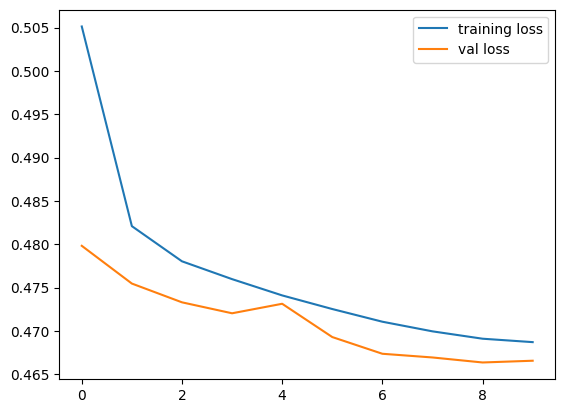

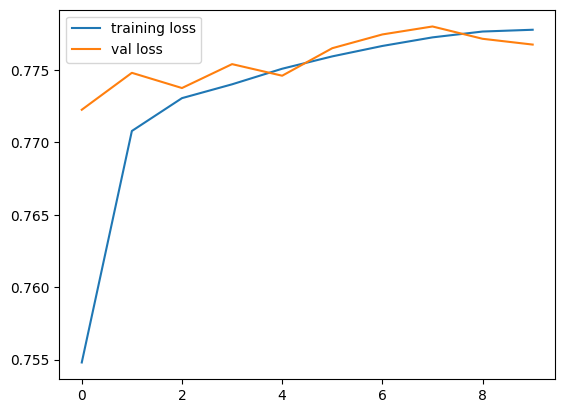

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step
      1/Unknown 0s 147ms/step

/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


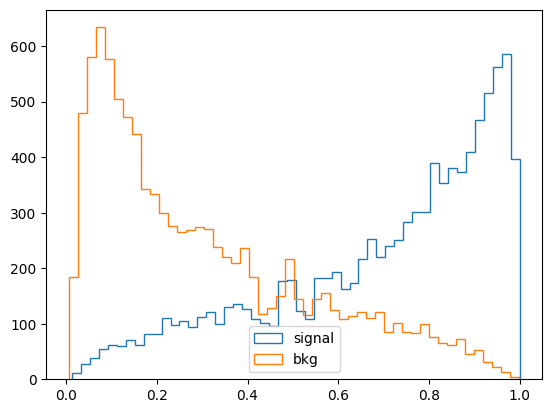

In [5]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=N_EPOCHS)

# evaluate the model
metrics_val = model.evaluate(val_dataset)
metrics_train = model.evaluate(train_dataset)

print("Validation: ", metrics_val)
print("Train: ", metrics_train)

# draw the learning curves
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['binary_accuracy'], label='training loss')
plt.plot(history.history['val_binary_accuracy'], label='val loss')
plt.legend()
plt.show()

## draw predictions
def pick_data(data, label):
    return data

def pick_sig(data, label):
    return label == 1
    
def pick_bkg(data, label):
    return label == 0

sig_data = val_dataset.unbatch()
sig_data = sig_data.filter(pick_sig)
sig_data = sig_data.map(pick_data)
sig_data = sig_data.batch(BATCH_SIZE)

bkg_data = val_dataset.unbatch()
bkg_data = bkg_data.filter(pick_bkg)
bkg_data = bkg_data.map(pick_data)
bkg_data = bkg_data.batch(BATCH_SIZE)

prediction_sig = model.predict(sig_data)
prediction_bkg = model.predict(bkg_data)

plt.hist(prediction_sig, bins=50, histtype='step', label='signal')
plt.hist(prediction_bkg, bins=50, histtype='step', label='bkg')
plt.legend()
plt.show()
